**Experimenting with RNN,LSTM,and GRU Models**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
import re
import pickle
from random import random, sample, seed
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
file = "drive/My Drive/Eluvio/Eluvio_DS_Challenge.csv"
df = pd.read_csv(file, sep = ',', parse_dates= ['date_created'],encoding='utf-8-sig') 

In [0]:
threshold = np.quantile(df['up_votes'], 0.6)
is_top_submission = [1 if i > threshold else 0 for i in df['up_votes']]
is_top_submission = np.array(is_top_submission)

In [0]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [0]:
def remove_punctuation(x):
  no_punct="".join([c for c in x if c not in string.punctuation])
  return no_punct

In [0]:
df['title']=df['title'].apply(lambda x:remove_punctuation(x))
tokenizer=RegexpTokenizer(r'\w+')
df["title"]=df["title"].apply(lambda x:tokenizer.tokenize(x.lower()))

In [0]:
listoftexts,listwords=[],[]
for line in df['title']:
        #exclude = set(string.punctuation)
        #line = ''.join(ch for ch in line if ch not in exclude)
        listwords=[]
        for word in line:
            listwords.append(word)
        listoftexts.append(listwords)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(listoftexts)
sequences = tokenizer.texts_to_sequences(listoftexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

Found 114097 unique tokens.


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-02-29 19:27:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-29 19:27:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-29 19:27:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
embeddings_index = {}
f = open(r'glove.6B.300d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
pickle.dump({'embeddings_index' : embeddings_index} , open('sample_data/content', 'wb'))

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=63,
                            trainable=False,mask_zero=True)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation,LSTM, GRU
from keras import optimizers
def RNN(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(SimpleRNN(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
def LSTMfunction(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
def GRUfunction(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(GRU(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
RNN_model=RNN(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 63, 300)           34229400  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 34,269,601
Trainable params: 40,201
Non-trainable params: 34,229,400
_________________________________________________________________
None


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, is_top_submission, test_size = 0.2, random_state = 143)

In [0]:
history=RNN_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_test),np.array(y_test)))



Train on 407388 samples, validate on 101848 samples
Epoch 1/5
407388/407388 [==============================] - 255s 627us/step - loss: 0.6455 - acc: 0.6290 - val_loss: 0.6462 - val_acc: 0.6198
Epoch 2/5
407388/407388 [==============================] - 256s 628us/step - loss: 0.6372 - acc: 0.6374 - val_loss: 0.6392 - val_acc: 0.6385
Epoch 3/5
407388/407388 [==============================] - 254s 624us/step - loss: 0.6337 - acc: 0.6414 - val_loss: 0.6364 - val_acc: 0.6361
Epoch 4/5
407388/407388 [==============================] - 254s 624us/step - loss: 0.6318 - acc: 0.6422 - val_loss: 0.6340 - val_acc: 0.6390
Epoch 5/5
407388/407388 [==============================] - 254s 624us/step - loss: 0.6282 - acc: 0.6453 - val_loss: 0.6323 - val_acc: 0.6434


In [0]:
LSTM_model=LSTMfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 63, 300)           34229400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 34,389,901
Trainable params: 160,501
Non-trainable params: 34,229,400
_________________________________________________________________
None


In [0]:
history=LSTM_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=8,validation_data=(np.array(X_test),np.array(y_test)))

Train on 407388 samples, validate on 101848 samples
Epoch 1/8
407388/407388 [==============================] - 781s 2ms/step - loss: 0.6375 - acc: 0.6387 - val_loss: 0.6305 - val_acc: 0.6475
Epoch 2/8
407388/407388 [==============================] - 773s 2ms/step - loss: 0.6246 - acc: 0.6507 - val_loss: 0.6242 - val_acc: 0.6517
Epoch 3/8
407388/407388 [==============================] - 780s 2ms/step - loss: 0.6170 - acc: 0.6581 - val_loss: 0.6222 - val_acc: 0.6552
Epoch 4/8
407388/407388 [==============================] - 772s 2ms/step - loss: 0.6087 - acc: 0.6651 - val_loss: 0.6244 - val_acc: 0.6529
Epoch 5/8
407388/407388 [==============================] - 783s 2ms/step - loss: 0.5992 - acc: 0.6729 - val_loss: 0.6258 - val_acc: 0.6506
Epoch 6/8
407388/407388 [==============================] - 773s 2ms/step - loss: 0.5889 - acc: 0.6818 - val_loss: 0.6303 - val_acc: 0.6506
Epoch 7/8
407388/407388 [==============================] - 780s 2ms/step - loss: 0.5774 - acc: 0.6909 - val_loss: 

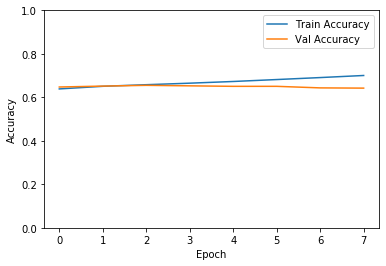

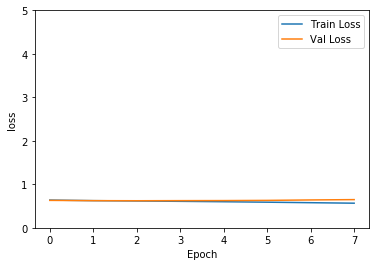

In [0]:
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['acc'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_acc'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)


In [0]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 63, 300)           34229400  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 34,349,801
Trainable params: 120,401
Non-trainable params: 34,229,400
_________________________________________________________________
None


In [0]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_test),np.array(y_test)))

Train on 407388 samples, validate on 101848 samples
Epoch 1/5
407388/407388 [==============================] - 598s 1ms/step - loss: 0.6390 - acc: 0.6372 - val_loss: 0.6287 - val_acc: 0.6488
Epoch 2/5
407388/407388 [==============================] - 599s 1ms/step - loss: 0.6244 - acc: 0.6512 - val_loss: 0.6241 - val_acc: 0.6534
Epoch 3/5
407388/407388 [==============================] - 594s 1ms/step - loss: 0.6165 - acc: 0.6584 - val_loss: 0.6289 - val_acc: 0.6483
Epoch 4/5
407388/407388 [==============================] - 603s 1ms/step - loss: 0.6088 - acc: 0.6660 - val_loss: 0.6233 - val_acc: 0.6533
Epoch 5/5
407388/407388 [==============================] - 597s 1ms/step - loss: 0.6002 - acc: 0.6736 - val_loss: 0.6258 - val_acc: 0.6519


**Summary:** Got an better accuracy with LSTM network which is 65.52